# BioJEPA v0.3

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math
import torch.serialization

import biojepa_ac_model as model
from bio_dataloader import PretrainLoader, TrainingLoader

## BioJEPA Model load

In [2]:
!nvidia-smi

Wed Jan  7 19:24:46 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             On  |   00000000:DD:00.0 Off |                    0 |
| N/A   34C    P0             89W /  700W |       6MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
torch.cuda.is_available()

True

In [4]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cuda


In [5]:
torch.manual_seed(1337)
random.seed(1337)

## Training Configs

In [6]:
data_dir = Path('/home/ubuntu')
train_dir = data_dir / 'training'
pretrain_dir = data_dir / 'pretraining'
checkpoint_dir = data_dir / 'checkpoint'
pert_dir = data_dir / 'pert_embd'
pert_embd_path = pert_dir / 'action_embeddings_esm2.npy'

In [7]:
print('Loading Action Embedding ...')
pert_embd = np.load(pert_embd_path)
print(f'Bank Loaded. Shape: {pert_embd.shape}')

Loading Action Embedding ...
Bank Loaded. Shape: (1087, 320)


In [8]:
batch_size = 64
n_embd = 256
pt_epochs = 100
training_file_chunk = 25000
pretraining_file_chunk = 50000
n_heads = 4
n_layers = 6
n_genes = 5000

In [9]:
torch.set_float32_matmul_precision('high')
config = model.BioJepaConfig(
    num_genes = n_genes,
    n_layer= n_layers,
    heads= n_heads,
    embed_dim = n_embd,
    n_pre_layer= n_layers
)
model = model.BioJepa(config, pert_embd=pert_embd).to(DEVICE)

In [10]:
print(f'Student/Teacher: {sum(p.numel() for p in model.student.parameters() if p.requires_grad)}')
print(f'ACpredictor: {sum(p.numel() for p in model.predictor.parameters() if p.requires_grad)}')

Student/Teacher: 6019840
ACpredictor: 7881216


### Pre-Training

In [11]:
pt_train_loader = PretrainLoader(batch_size=batch_size, split='train', data_dir=pretrain_dir, device=DEVICE)
pt_val_loader = PretrainLoader(batch_size=batch_size, split='val', data_dir=pretrain_dir, device=DEVICE)

found 2 shards for split train
loading /home/ubuntu/pretraining/train/pt_shard_k562e_train_0000.npz
found 1 shards for split val
loading /home/ubuntu/pretraining/val/pt_shard_k562e_val_0000.npz


In [12]:
pt_train_total = 112373
pt_val_total = 11044
steps_per_epoch = pt_train_total // batch_size
pt_max_steps = pt_epochs * steps_per_epoch
steps_per_epoch, pt_max_steps

(1755, 175500)

In [13]:
pt_LR = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=pt_LR, weight_decay=0.05)

In [14]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=pt_LR, total_steps=pt_max_steps, pct_start=0.05
)

In [15]:
pt_lossi = []
step = 0
total_epoch_loss = 0

In [16]:
model.train()

for step in range(pt_max_steps):
    last_step = (step == pt_max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 250 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                x_val, total_val = pt_val_loader.next_batch()

                val_loss = model.forward_pretrain(x_val, total_val)
                val_loss_accum += val_loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')
            
        # with open(log_file, 'a') as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')
        model.train()


    if step > 0 and (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_pt_ckpt_{step}.pt')

    # Pre-Training
    x, total = pt_train_loader.next_batch()
    
    optimizer.zero_grad()
    
    loss = model.forward_pretrain(x, total)
    loss.backward()

    # gradient clipping
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    # Update Teacher (V-JEPA Momentum)
    model.update_teacher()
    
    scheduler.step()
    
    pt_lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 100 == 0:
        print(f'Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}')
    
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f'=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===')
        total_epoch_loss = 0.0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_pt_ckpt_{step}_final.pt')



val loss: 75.0255
Step 0 | Loss: 75.02950 | LR: 4.00e-06
Step 100 | Loss: 62.89892 | LR: 4.03e-06
Step 200 | Loss: 57.78164 | LR: 4.12e-06
val loss: 56.4037
Step 300 | Loss: 55.36280 | LR: 4.28e-06
Step 400 | Loss: 53.85463 | LR: 4.49e-06
val loss: 52.7864
Step 500 | Loss: 52.79113 | LR: 4.77e-06
Step 600 | Loss: 51.90943 | LR: 5.11e-06
Step 700 | Loss: 51.16814 | LR: 5.50e-06
val loss: 50.8154
Step 800 | Loss: 50.51602 | LR: 5.96e-06
Step 900 | Loss: 50.04613 | LR: 6.48e-06
val loss: 49.7251
Step 1000 | Loss: 49.73059 | LR: 7.05e-06
Step 1100 | Loss: 49.61456 | LR: 7.68e-06
loading /home/ubuntu/pretraining/train/pt_shard_k562e_train_0001.npz
Step 1200 | Loss: 49.57229 | LR: 8.37e-06
val loss: 49.5472
Step 1300 | Loss: 49.53524 | LR: 9.11e-06
Step 1400 | Loss: 49.54256 | LR: 9.91e-06
val loss: 49.5475
Step 1500 | Loss: 49.55655 | LR: 1.08e-05
Step 1600 | Loss: 49.53616 | LR: 1.17e-05
Step 1700 | Loss: 49.54992 | LR: 1.26e-05
val loss: 49.5373
=== Step 1754 Done. Avg Loss: 52.48167 ===


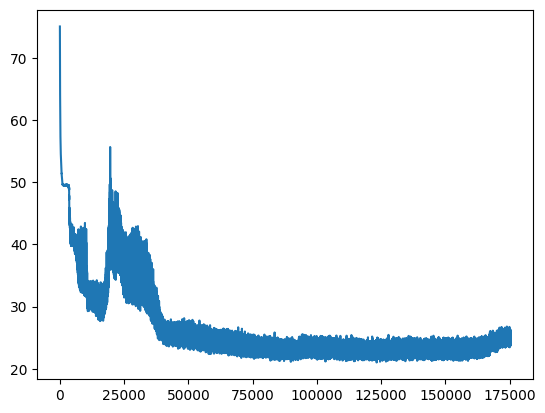

In [17]:
plt.plot(pt_lossi[:])
#plt.yscale('log')

## Loading Pretrained Head

In [16]:
checkpoint_path = checkpoint_dir / 'bio_jepa_pt_ckpt_175499_final.pt'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

keys = model.load_state_dict(checkpoint['model'])
keys

<All keys matched successfully>

## Training

In [17]:
batch_size = 32
LR = 1e-4
epochs = 20

In [18]:
train_loader = TrainingLoader(batch_size=batch_size, split='train', data_dir=train_dir, device=DEVICE)
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)

found 3 shards for split train
loading /home/ubuntu/training/train/shard_k562e_train_0001.npz
found 1 shards for split val
loading /home/ubuntu/training/val/shard_k562e_val_0000.npz


In [19]:
steps_per_epoch = 101682 // batch_size
max_steps = epochs * steps_per_epoch
steps_per_epoch, max_steps

(3177, 63540)

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

In [21]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, total_steps=max_steps, pct_start=0.05
)

In [22]:
lossi = []
step = 0
total_epoch_loss = 0

In [23]:
model.freeze_encoders()
model.train()

for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 250 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                xc, xct, xt, xtt, aid = val_loader.next_batch()

                val_loss = model(xc, xct, xt, xtt, aid)
                val_loss_accum += val_loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')

        # with open(log_file, "a") as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')
        model.train()


    if step > 0 and (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}.pt')


    # Get Batch (xc=Control, xt=Treated/Case)
    xc, xct, xt, xtt, aid = train_loader.next_batch()
    
    optimizer.zero_grad()
    
    loss = model(xc, xct, xt, xtt, aid)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    
    scheduler.step()
    
    lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 100 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}_final.pt')



val loss: 76.6528
Step 0 | Loss: 78.92419 | LR: 4.00e-06
Step 100 | Loss: 48.38370 | LR: 4.24e-06
Step 200 | Loss: 43.02344 | LR: 4.95e-06
val loss: 44.2075
Step 300 | Loss: 42.58173 | LR: 6.11e-06
Step 400 | Loss: 41.69090 | LR: 7.73e-06
val loss: 41.5879
Step 500 | Loss: 40.48545 | LR: 9.77e-06
Step 600 | Loss: 40.02102 | LR: 1.22e-05
Step 700 | Loss: 40.27300 | LR: 1.51e-05
val loss: 39.6276
Step 800 | Loss: 40.05817 | LR: 1.83e-05
Step 900 | Loss: 38.49232 | LR: 2.18e-05
val loss: 39.3469
Step 1000 | Loss: 39.11641 | LR: 2.57e-05
Step 1100 | Loss: 37.54802 | LR: 2.98e-05
Step 1200 | Loss: 38.63822 | LR: 3.41e-05
val loss: 39.0259
Step 1300 | Loss: 37.82827 | LR: 3.86e-05
Step 1400 | Loss: 37.67643 | LR: 4.32e-05
val loss: 38.5513
Step 1500 | Loss: 38.48582 | LR: 4.79e-05
loading /home/ubuntu/training/train/shard_k562e_train_0000.npz
Step 1600 | Loss: 37.25166 | LR: 5.26e-05
Step 1700 | Loss: 37.44345 | LR: 5.74e-05
val loss: 36.4130
Step 1800 | Loss: 36.20288 | LR: 6.20e-05
Step 19

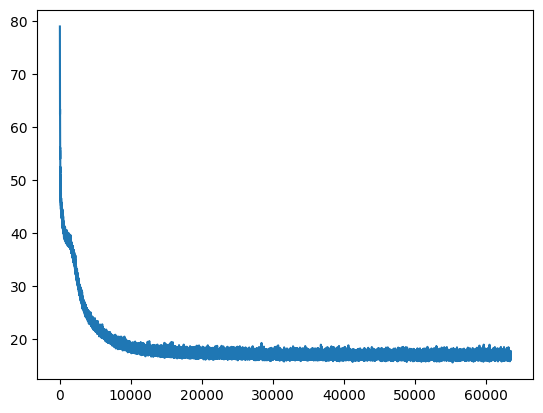

In [24]:
plt.plot(lossi[:])
#plt.yscale('log')